In [1]:
import sys
print(sys.version)

3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


## Install Required Libraries 

In [2]:
# %pip install haystack-ai transformers accelerate bitsandbytes sentence_transformers pypdf elasticsearch-haystack torch numpy

## Import Required Libraries 

In [2]:
# %pip install rich

In [7]:
from IPython.display import Image
from pprint import pprint
import torch
import rich
import random

In [6]:
from haystack import Pipeline, Document
#from haystack.document_stores import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.writers.document_writer import DuplicatePolicy
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
#from elasticsearch_haystack.document_store import ElasticsearchDocumentStore
#from elasticsearch_haystack.embedding_retriever import ElasticsearchEmbeddingRetriever
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.components.builders import PromptBuilder

d:\Chatbot_on_Documents\Haystack\chatbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize Document Store 

In [8]:
document_store_dfpds = ElasticsearchDocumentStore(hosts = "http://localhost:9200")
print(document_store_dfpds.count_documents())

0


## Pipeline for document convertion, preprocessing,embedding & to store them in VectorDB

In [9]:
pipeline = Pipeline()

pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=400))
pipeline.add_component("doc_embedder", SentenceTransformersDocumentEmbedder(model="thenlper/gte-base", device="cuda:0",))
pipeline.add_component("writer", DocumentWriter(document_store=document_store_dfpds,policy=DuplicatePolicy.OVERWRITE))

pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "doc_embedder")
pipeline.connect("doc_embedder", "writer")

In [ ]:
pipeline.draw("pipeline.png")
Image(filename='pipeline.png')

In [11]:
import os
from pathlib import Path
file_paths = ["data" / Path(name) for name in os.listdir("data")]

In [9]:
file_paths

[WindowsPath('data/DFPDS21.pdf')]

In [12]:
pipeline.run({"converter": {"sources": file_paths}})

AssertionError: Torch not compiled with CUDA enabled

In [13]:
import torch
print(torch.__version__)

2.2.0+cpu


In [4]:
import sys
print(sys.executable)

d:\Chatbot_on_Documents\Haystack\chatbot\Scripts\python.exe


In [1]:
import torch
print(torch.cuda.is_available())  # True if CUDA is enabled

False


## Checking documents stored in VectorDB

In [6]:
len(document_store_dfpds.filter_documents())

91

In [7]:
pprint(document_store_dfpds.filter_documents()[45].meta)

{'file_path': 'data2/DFPDS21.pdf',
 'source_id': '61332544334c212279e087776deab7308d05af2da5bb1de7a775f593201a91ed'}


In [7]:
pprint(document_store_dfpds.filter_documents()[65].content)

('the period to which lost documents pertain.\n'
 '(d) Irregularities connected with the use of M.T.\n'
 '2. In the case of objections which involve loss to the State, efforts will '
 'be made to assess the actual/ approximate financial value of the loss. These '
 'powers are to be exercised only if –\n'
 '(a) The necessity for and the practicability of recovery has been considered '
 'by the CFA.\n'
 '(b) The irregularity does not disclose a defect in the rules or regulations '
 'the amendment of which requires the sanction of the Government vide Rule 157 '
 'FR Part I Vol I.(c) The authorities concerned (or their predecessors) are '
 'themselves not personally responsible for the loss/ overpayment/ '
 'irregularity.(d) Prior approval of the next higher financial authority shall '
 'be obtained in respect of cases mentioned at (c) above.(e) Objections, which '
 'do not involve any loss to the State or when the monetary loss is not '
 'assessable, be referred to the respective Administ

## Initialize Generator

In [8]:

generator = HuggingFaceLocalGenerator("mistralai/Mistral-7B-Instruct-v0.1",
                                 huggingface_pipeline_kwargs={"device_map":"auto",
                                               "model_kwargs":{"load_in_4bit":True,
                                                "bnb_4bit_use_double_quant":True,
                                                "bnb_4bit_quant_type":"nf4",
                                                "bnb_4bit_compute_dtype":torch.bfloat16}},
                                 generation_kwargs={"max_new_tokens": 800})

In [9]:
generator.warm_up()

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


In [ ]:
# quick check for generator 
rich.print(generator.run("Please write a poem about America."))

## Creating Prompt template 

In [10]:

prompt_template = """<|system|> Using the information contained in the context, give a comprehensive answer to the question.
If the answer is contained in the context, also report the source data.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
  {% for doc in documents %}
  {{ doc.content }} 
  {% endfor %};
  \nQuestion: {{query}}
  </s>
  
Example:
\nQuestion:What are the documents and stages for undertaking an open tender enquiry under DFPDS schedule 19.3?
\nAnswer: 1. In Principal Approval (IPA):
   - What happens: Getting the initial approval to proceed with the procurement.
   - Documents involved: Explanation of the project, what needs to be done, how much it will cost, and any financial support needed.
   - Key point: This approval comes from the Central Financial Assistance (CFA) after proper discussions.

2. Acceptance of Necessity (AoN):
   - What happens: Confirming that there's a genuine need for the procurement and estimating the costs.
   - Documents involved: Cost estimates, comparisons with previous purchases, and making sure the plan is clear.
   - Key point: The CFA approves this, considering suggestions from the Independent Financial Advisor (IFA) if needed.

3. Upload Bid on GeM:
   - What happens: Putting the details of the procurement online, especially on the Government e-Marketplace (GeM).
   - Key point: Timing depends on the type of procurement.

4. Technical Evaluation Committee (TEC):
   - What happens: Checking if the bidders meet the technical requirements.
   - Documents involved: Scrutinizing documents submitted by bidders and ensuring they meet the specified criteria.
   - Key point: Non-compliant bidders get a chance to fix issues within 48 hours.

5. Benchmarking:
   - What happens: Comparing the estimated costs with market prices to ensure fairness.
   - Documents involved: Checking how prices compare to what was estimated.
   - Key point: Prices are set a bit higher than the initial estimates.

6. Commercial Opening of Bid (COB):
   - What happens: Opening bids to see the prices submitted by compliant bidders.
   - Key point: Analysis of prices helps decide if negotiation is needed with the top bidder. Reverse auction may happen if multiple bidders qualify.

7. Cost Negotiation Committee (CNC)/Price Negotiation Committee (PNC):
   - What happens: Checking if the costs can be negotiated and if it aligns with guidelines.
   - Key point: Negotiations are done, and financial details are recommended for approval. All this is reviewed by the CFA.

8. Expenditure Angle Sanction (EAS):
   - What happens: Getting the final approval for the expenses from the CFA.
   - Key point: This is the green light to go ahead with the procurement.

9. Supply Order:
   - What happens: Placing the order with the chosen bidder.
   - Key point: The procurement process is complete, and the chosen bidder is officially hired to do the job.

<|assistant|>
\nAnswer:
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [ ]:
# rag = Pipeline()
# rag.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
# rag.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store_dfpds, top_k=3))
# rag.add_component("prompt_builder", prompt_builder)
# rag.add_component("llm", generator)

# rag.connect("text_embedder", "retriever")
# rag.connect("retriever.documents", "prompt_builder.documents")
# rag.connect("prompt_builder.prompt", "llm.prompt")

In [ ]:
# query_pipeline = Pipeline()
# query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
# query_pipeline.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store_dfpds,top_k=3))
# query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

In [ ]:
# rag.draw("rag.png")
# Image(filename='rag.png')

# def get_generative_answer(query):

#   results = rag.run({
#       "text_embedder": {"text": query},
#       "prompt_builder": {"query": query}
#     }
#   )

#   answer = results["llm"]["replies"][0]
#   rich.print(answer)
  
#   print(get_generative_answer("What is ARMY SCHEDULES OF POWERS? "))

## Function that get answer & relevant documents for it

In [12]:
def get_answer_with_relevant_docs(query, rag_pipeline, query_pipeline):
    # Use the query pipeline to retrieve relevant documents
    relevant_docs = query_pipeline.run({"text_embedder": {"text": query}})['retriever']['documents']

    # Extract relevant document IDs and page numbers
    relevant_doc_info = [(doc.id,doc.meta.get("file_path"), doc.meta.get("page_number", "N/A"),doc.content) for doc in relevant_docs]
    #relevant_doc_paths = [doc.meta.get("file_path") for doc in relevant_docs]
    # Use the RAG pipeline to generate an answer
    results = rag_pipeline.run({
        "text_embedder": {"text": query},
        "prompt_builder": {"query": query}
    })

    # Extract the generated answer
    answer = results["llm"]["replies"][0]

    return answer, relevant_doc_info

## Pipeline for RAG & document retrieval 

In [13]:

# Create RAG pipeline
rag_pipeline2 = Pipeline()
rag_pipeline2.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
rag_pipeline2.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store_dfpds, top_k=3))
rag_pipeline2.add_component("prompt_builder", prompt_builder)
rag_pipeline2.add_component("llm", generator)
rag_pipeline2.connect("text_embedder", "retriever")
rag_pipeline2.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline2.connect("prompt_builder.prompt", "llm.prompt")

# Create query pipeline
query_pipelin2 = Pipeline()
query_pipelin2.add_component("text_embedder", SentenceTransformersTextEmbedder(model_name_or_path="thenlper/gte-large", device="cuda:0"))
query_pipelin2.add_component("retriever", ElasticsearchEmbeddingRetriever(document_store=document_store_dfpds, top_k=3))
query_pipelin2.connect("text_embedder.embedding", "retriever.query_embedding")



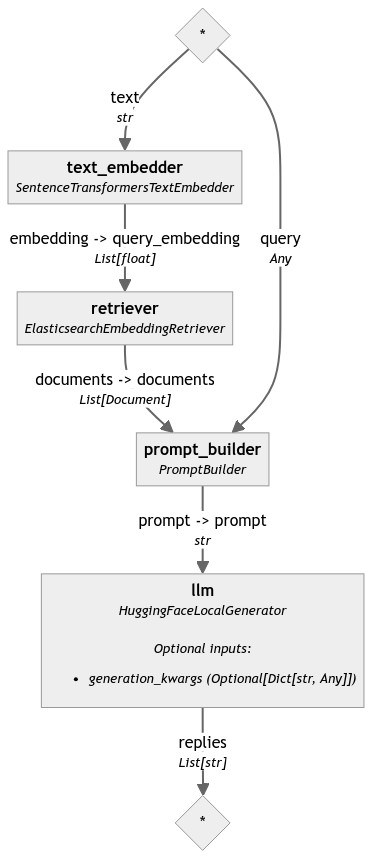

In [23]:
rag_pipeline2.draw("rag_pipeline2.png")
Image(filename='rag_pipeline2.png')

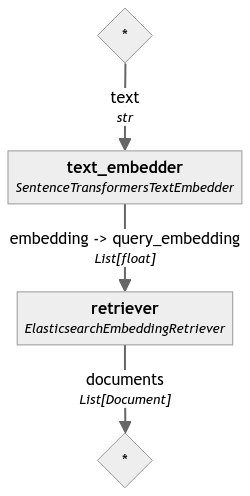

In [24]:
query_pipelin2.draw("query_pipelin2.png")
Image(filename='query_pipelin2.png')

## Example Usage

In [15]:
query = "What you know about Air Force Schedules of Powers 2021?"
answer, relevant_doc_info = get_answer_with_relevant_docs(query, rag_pipeline2, query_pipelin2)

# Print the answer
print('Answer:')
rich.print(answer)

# Print relevant documents with page numbers
print('Relevant Documents:')
for doc_id, doc_path,page_number,doc_content in relevant_doc_info:
    print(f"Document ID: {doc_id}\t,Document Path: {doc_path}\t, Page Number: {page_number}")
    print("-------------------------------------------------------------------------------")
    print(f"Document Content:\n{doc_content}")
    print("========================== End oF Document=====================================\n")

Batches: 100%|██████████| 1/1 [00:00<00:00, 54.09it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Answer:


The Air Force Schedules of Powers 2021 (AFSP-2021) is a document that outlines the financial powers delegated to 
the Air Force for various activities. It is based on the Defence Financial Powers Delegation Schedule (DFPDS) 2016 
and categorizes the powers into various schedules, which are further divided into sub-schedules. The procurement 
powers are defined as the authority to acquire all types of items, goods, equipment, stores, spares, tools, 
calibration equipment, technical literature/documentation, software, etc., as well as all types of services, 
including repair, modifications, transportation, insurance, advertisement, registration, training, recruitment, 
delivery, special services, leasing, technical assessment, consultancy, systems study, software development, 
maintenance (AMC), LRC, STA, updates, life extension, refurbishment, fabrication, stores for development of product
improvement, packing, unpacking, preservation, service contracts hiring, etc., related to particular cases of 
procurement. The AFSP-2021 also includes provisions for annual maintenance contracts (AMC) of communication 
networks/equipment, including hardware, software, and professional services.

Relevant Documents:
Document ID: d97de07282f47e3a50309d12ff997afaefa7f2573e87828a6d962fa29d3c2c67	,Document Path: data2/DFPDS21.pdf	, Page Number: N/A
-------------------------------------------------------------------------------
Document Content:
Powers-2021 (NSP-2021)iii. Air Force Schedules of Powers-2021 (AFSP-2021)iv. IDS Schedules of Powers-2021 (ISP-2021)
3. Keeping in view the Government’s eco-friendly initiative, a soft copy of this MoD Order is attached for easy distribution to CFAs, PIFAs/IFAs, PCsDA/ CsDA, field formations etc.
4. Clarifications or interpretation of provisions contained in this Government Order will be regulated as per para 12 of Guidelines related to Schedules of Financial Powers.
5. This issues with the approval of Hon’ble Raksha Mantri.
Ambarish Barman
Director
Distribution:
O/o Raksha Mantri O/o Raksha Rajya Mantri CDS COAS CNS CASSecretary (DMA)/ Defence Secretary/ Secretary (DP)/ Secretary (R&D)/ Secretary (Defence Finance)/ Secretary (ESW)
CGDA DGAD